# nb-model_xg-model-neural-process-1

In [1]:
import sys
import os
from os import sep
from os.path import dirname, realpath
from pathlib import Path
from functools import partial
import logging

def get_cwd(fname, subdir, crunch_dir=realpath(Path.home()) +sep +'crunch' +sep):
    """
    Convenience function to make a directory string for the current file based on inputs.
    Jupyter Notebook in Anaconda invokes the Python interpreter in Anaconda's subdirectory
    which is why changing sys.argv[0] is necessary. In the future a better way to do this
    should be preferred..
    """
    return crunch_dir +subdir +fname

def fix_path(cwd):
    """
    Convenience function to fix argv and python path so that jupyter notebook can run the same as
    any script in crunch.
    """
    sys.argv[0] = cwd
    module_path = os.path.abspath(os.path.join('..'))
    if module_path not in sys.path:
        sys.path.append(module_path)

fname = 'nb-model_xg-model-neural-process-1.ipynb'
dir_name = 'model'
fix_path(get_cwd(fname, dir_name +sep))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning import loggers as pl_loggers

from ipywidgets import interact, interactive, fixed
from IPython.display import display

pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 50)

from common_util import MODEL_DIR, is_valid, isnt, compose, pd_split_ternary_to_binary, df_del_midx_level, midx_intersect, pd_get_midx_level, pd_rows, df_midx_restack
from model.common import DATASET_DIR, XG_PROCESS_DIR, XG_DATA_DIR, XG_DIR, PYTORCH_MODELS_DIR, TEST_RATIO, VAL_RATIO, EXPECTED_NUM_HOURS, default_dataset
from model.xg_util import get_xg_feature_dfs, get_xg_label_target_dfs, get_hardcoded_daily_dfs, get_hardcoded_hourly_dfs
from model.np_util import AttentiveNP, StackedTCN
from model.pl_generic import GenericModel
from model.pl_np import NP
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)

%autoreload 1
%aimport model.np_util, model.pl_np, model.pl_generic, model.metrics_util, model.model_util

CRITICAL:root:script location: /home/kev/crunch/model/nb-model_xg-model-neural-process-1.ipynb
CRITICAL:root:using project dir: /home/kev/crunch/


Prune the xg data down to the data of interest to use in further experiments.

## Load Data

In [2]:
assets = ['sp_500', 'russell_2000', 'nasdaq_100', 'dow_jones']
chosen_asset = assets[0]

fd = get_xg_feature_dfs(chosen_asset)
ld, td = get_xg_label_target_dfs(chosen_asset)

# daily data axefiles
d_all_common = ['dwrmx', 'dwrod', 'dwrpt', 'dwrzn', 'dffd']
d_extra = ['dlogret', 'dohlca', 'ddiff', 'dc', 'dwrxmx']

# hourly data axefiles
h_all_common = ['hdmx', 'hdod', 'hdpt', 'hdzn']
h_extra = ['hdgau', 'hduni', 'hohlca']

## Select Data

In [3]:
d_pba = get_hardcoded_daily_dfs(fd, 'pba')
d_vol = get_hardcoded_daily_dfs(fd, 'vol')
d_buzz = get_hardcoded_daily_dfs(fd, 'buzz')
d_nonbuzz = get_hardcoded_daily_dfs(fd, 'buzz')
h_pba = get_hardcoded_hourly_dfs(fd, 'pba')
h_vol = get_hardcoded_hourly_dfs(fd, 'vol')
h_buzz = get_hardcoded_hourly_dfs(fd, 'buzz')

In [4]:
# Returns (AR)
chosen_f = fd['d']['pba']['dret']['pba_hlh_hdxret_dret']
chosen_f = fd['d']['pba']['dret']['pba_hoc_hdxret_dret']
#chosen_f = fd['d']['pba']['ddir']['pba_hoc_hdxret_ddir']

In [5]:
# Daily Features
# chosen_f = d_pba
chosen_f = fd['d']['pba']['ddir']['pba_hoc_hdxret_ddir']

In [6]:
# fd['d']['pba']
# fd['d']['pba']['dohlca']['pba_dohlca'].unstack().pct_change().dropna().corr()
# fd['d']['vol']['dohlca']['vol_dohlca'].unstack().pct_change().dropna().corr()

In [7]:
# Hourly Features
chosen_f = h_pba
chosen_f = fd['h']['pba']['hdmx']['pba_hohlca_hdmx']

# # Random 'Features':
# chosen_f = pd.DataFrame(np.random.rand(len(chosen_f)), index=chosen_f.index).rename({chosen_f.index.levels[1][0]:

### Choose Labels/Targets and Process

In [8]:
# predict ddir(t)
chosen_l = pd_split_ternary_to_binary(ld['hoc']['pba']['ddir'].replace(to_replace=-1, value=0))
chosen_t = pd_split_ternary_to_binary(td['hoc']['pba']['dret'])

In [9]:
# # predict thresholded direction: ddir1(t)
# chosen_l_len = len(ld['hoc']['pba']['ddir1_log'].columns)
# chosen_l = pd_split_ternary_to_binary(ld['hoc']['pba']['ddir1_log'])
# chosen_l = chosen_l.sum(level=0)#+len(chosen_l.columns)
# chosen_l = (chosen_l[chosen_l!=0] + chosen_l_len).fillna(0).astype(int)
# chosen_l = df_add_midx_level(chosen_l, 'pba_hoc_hdxret1_ddir1', loc=1, name='id1')

# chosen_t = pd_split_ternary_to_binary(td['hoc']['pba']['dret1_log']).abs().max(level=0)
# chosen_t = df_add_midx_level(chosen_t, 'pba_hoc_hdxret1_dret1', loc=1, name='id1')
# #chosen_l = chosen_l.sum(level=0)#+len(chosen_l.columns)
# #chosen_l

In [10]:
# 'Predict' the present ddir(t-1), (sanity check)
#chosen_l = pd_split_ternary_to_binary(df_del_midx_level(fd['d']['pba']['ddir']['pba_hoc_hdxret_ddir'].rename(columns={-1:'pba_hoc_hdxret_ddir'}), loc=1).replace(to_replace=-1, value=0).astype(int))
#chosen_t = pd_split_ternary_to_binary(df_del_midx_level(fd['d']['pba']['dret']['pba_hoc_hdxret_dret'].rename(columns={-1:'pba_hoc_hdxret_dret'}), loc=1))

### Get Common Indexed Rows (Intersect First Level of MultiIndex)

In [11]:
year_interval = ('2009', '2018')
common_idx = midx_intersect(pd_get_midx_level(chosen_f), pd_get_midx_level(chosen_l), pd_get_midx_level(chosen_t))
common_idx = common_idx[(common_idx > year_interval[0]) & (common_idx < year_interval[1])]
feature_df, label_df, target_df = map(compose(partial(pd_rows, idx=common_idx), df_midx_restack), [chosen_f, chosen_l, chosen_t])
assert(all(feature_df.index.levels[0]==label_df.index.levels[0]))
assert(all(feature_df.index.levels[0]==target_df.index.levels[0]))

## Neural Process

In [18]:
# m_params, t_params = StackedTCN.suggest_params(add_ob=True), GenericModel.suggest_params()
# mdl = GenericModel(StackedTCN, m_params, t_params, (feature_df, label_df, target_df))

In [14]:
m_params, t_params = AttentiveNP.suggest_params(), NP.suggest_params()
t_params['epochs'] = 15
mdl = NP(AttentiveNP, m_params, t_params, (feature_df, label_df, target_df))
escb = EarlyStopping(monitor='val_loss', min_delta=0.00, patience=30, verbose=False, mode='min')
tb_logger = pl_loggers.TensorBoardLogger('lightning_logs', name='tb')
csv_logger = pl_loggers.csv_logs.CSVLogger('lightning_logs', name='csv')
trainer = pl.Trainer(max_epochs=t_params['epochs'], logger=[tb_logger, csv_logger],
		val_percent_check=.5, weights_summary='top',
		gradient_clip_val=0., track_grad_norm=2, auto_lr_find=False, 
		default_root_dir='lightning_logs',
		gpus=-1 if(torch.cuda.is_available()) else None,
		amp_level='O1', precision=16)

GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.
INFO:lightning:Using native 16bit precision.


In [15]:
mdl

NP(
  (ret_fn): SimulatedReturn()
  (model): AttentiveNP(
    (det_encoder): DetEncoder(
      (input_encoder): StackedTCN(
        (model): Sequential(
          (rb_0): ResidualBlock(
            (net): Sequential(
              (tl_0_0): TemporalLayer1d(
                (layer): Sequential(
                  (0): Conv1d(6, 128, kernel_size=(3,), stride=(1,), padding=(2,))
                  (1): ELU(alpha=1.0)
                  (2): Dropout(p=0.0, inplace=False)
                )
              )
              (tl_0_1): TemporalLayer1d(
                (layer): Sequential(
                  (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(2,))
                  (1): ELU(alpha=1.0)
                  (2): Dropout(p=0.5, inplace=False)
                )
              )
              (tl_0_2): TemporalLayer1d(
                (layer): Sequential(
                  (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(4,))
                

In [13]:
trainer.fit(mdl)

/home/kev/miniconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  warnings.warn(*args, **kwargs)

  | Name   | Type            | Params
-------------------------------------------
0 | model  | AttentiveNP     | 1 M   
1 | ret_fn | SimulatedReturn | 0     
INFO:lightning:
  | Name   | Type            | Params
-------------------------------------------
0 | model  | AttentiveNP     | 1 M   
1 | ret_fn | SimulatedReturn | 0     
/home/kev/miniconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/home/kev/miniconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Saving latest checkpoint..
INFO:lightning:Saving latest checkpoint..


1

In [ ]:
def init_random_seed(seed):
    # https://pytorch.org/docs/stable/notes/randomness.html
    np.random.seed(seed)
    torch.random.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [44]:
alpha = torch.tensor([[0.7178],
        [0.9132],
        [0.8583],
        [0.8679],
        [0.8830],
        [0.6960],
        [0.7145],
        [0.7236],
        [0.7256],
        [0.8372],
        [0.8938],
        [0.7015],
        [0.7416],
        [0.7968],
        [0.8381],
        [0.7227],
        [0.6914],
        [0.7258],
        [0.8054],
        [0.8606],
        [0.7868],
        [0.7187],
        [0.7623],
        [0.7986],
        [0.7057],
        [0.8149],
        [0.7915],
        [0.6627],
        [1.0297],
        [0.6368],
        [0.6907],
        [0.6212],
        [0.5667],
        [0.8088],
        [0.7017],
        [0.5996],
        [0.7835],
        [0.5984],
        [0.6511],
        [0.6205],
        [0.8320],
        [0.6591],
        [0.6522],
        [0.5667],
        [0.6661],
        [0.7151],
        [0.6168],
        [0.7309],
        [0.6816],
        [0.6333],
        [0.8586],
        [0.8077],
        [0.7237],
        [0.8427],
        [0.6740],
        [0.7795],
        [0.8889],
        [0.6303],
        [0.5875],
        [0.7972],
        [0.7637],
        [0.7919],
        [0.7291],
        [0.7476]], device='cuda:0')

beta = torch.tensor([[1.0344],
        [0.5334],
        [0.4402],
        [0.6664],
        [0.6958],
        [0.7333],
        [1.0591],
        [0.6792],
        [1.0880],
        [0.8903],
        [0.6510],
        [0.7187],
        [0.6258],
        [0.7643],
        [0.6647],
        [1.0063],
        [0.6665],
        [0.6710],
        [0.6315],
        [0.6970],
        [0.6960],
        [0.8488],
        [0.8547],
        [0.6118],
        [0.7652],
        [0.6054],
        [0.6840],
        [0.7666],
        [0.8978],
        [0.5133],
        [0.9799],
        [0.8981],
        [0.6387],
        [0.6454],
        [0.6947],
        [0.9924],
        [0.7703],
        [0.8720],
        [0.8859],
        [0.7997],
        [0.9635],
        [0.5297],
        [1.0919],
        [0.8375],
        [0.6416],
        [0.7111],
        [0.9431],
        [0.8264],
        [0.4814],
        [0.7436],
        [0.7247],
        [0.6305],
        [0.8898],
        [0.8594],
        [0.7563],
        [0.7000],
        [0.8499],
        [0.8457],
        [0.6647],
        [0.5826],
        [0.7324],
        [0.6652],
        [0.8827],
        [0.7915]], device='cuda:0')

target_y = torch.tensor([0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
        0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1,
        1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0], device='cuda:0')

y_pred = torch.tensor([[0.4097],
        [0.6313],
        [0.6610],
        [0.5657],
        [0.5593],
        [0.4869],
        [0.4029],
        [0.5158],
        [0.4001],
        [0.4846],
        [0.5786],
        [0.4939],
        [0.5424],
        [0.5104],
        [0.5577],
        [0.4180],
        [0.5092],
        [0.5196],
        [0.5605],
        [0.5525],
        [0.5306],
        [0.4585],
        [0.4715],
        [0.5662],
        [0.4798],
        [0.5737],
        [0.5364],
        [0.4636],
        [0.5342],
        [0.5537],
        [0.4135],
        [0.4089],
        [0.4701],
        [0.5562],
        [0.5025],
        [0.3766],
        [0.5042],
        [0.4070],
        [0.4236],
        [0.4369],
        [0.4634],
        [0.5544],
        [0.3739],
        [0.4036],
        [0.5094],
        [0.5014],
        [0.3954],
        [0.4694],
        [0.5861],
        [0.4599],
        [0.5423],
        [0.5616],
        [0.4485],
        [0.4951],
        [0.4712],
        [0.5268],
        [0.5112],
        [0.4270],
        [0.4692],
        [0.5778],
        [0.5105],
        [0.5435],
        [0.4524],
        [0.4858]], device='cuda:0')

In [19]:
d = torch.distributions.Beta(alpha, beta)

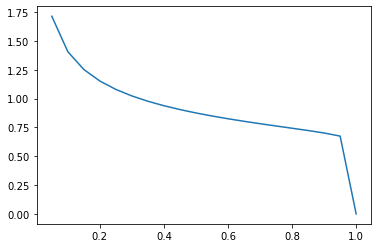

In [265]:
x_val = torch.arange(0.0, 1.05, 0.05, device='cuda:0')
plt.plot(x_val.cpu(), d.log_prob(x_val)[0].exp().cpu())

In [66]:
torch.distributions.Normal(0, 1).sample()

tensor(2.0499)

In [44]:
torch.distributions.Bernoulli(probs=.9).log_prob(.7)

tensor(-0.7645)

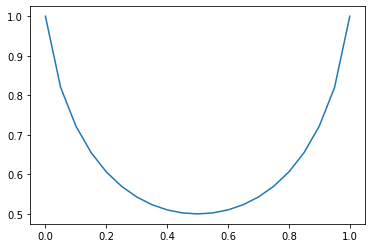

In [43]:
dist = torch.distributions.Bernoulli(probs=torch.arange(0.0, 1.05, 0.05, device='cpu'))
x_val = torch.arange(0.0, 1.05, 0.05, device='cpu')
plt.plot(x_val.cpu(), dist.log_prob(x_val).exp().cpu())

In [44]:
dist.sample()

/home/kev/miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1.,
        1., 1., 1.])

In [40]:
dist.log_prob(.4).exp()

tensor(7.0111e-05)